In [4]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [3]:
sys.path.append('../src')
from fit_clinicalbert import split_train_val_test
import plot_helpers as ph

In [11]:
experiment_id = "0"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

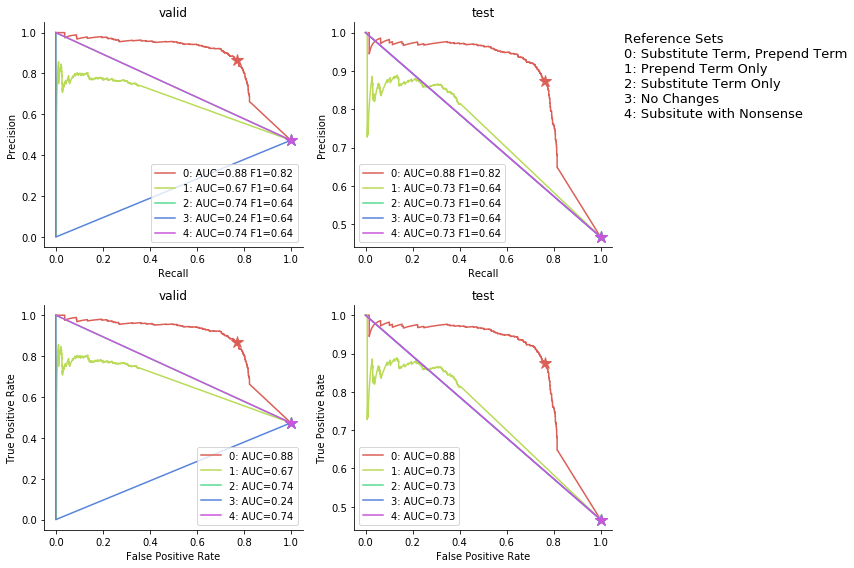

In [49]:
resfiles = experiment['bestepoch']
colors = sns.color_palette("hls", len(resfiles))

plt.figure(figsize=(12,8))
plotcounter = 1


for split in ('valid', 'test'):
    plt.subplot(2, 2, plotcounter)
    plotcounter += 1
    plt.title(split)

    for i, resfile in enumerate(resfiles):
        
        df = pd.read_csv(os.path.join('..', resfile), index_col=0)
        df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
        split_df = df[df['split']==split]
        
        prdata = ph.prdata(split_df['label'], split_df['Pred1'])

        plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                 label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                )
        plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    sns.despine()

for split in ('valid', 'test'):
    plt.subplot(2, 2, plotcounter)
    plotcounter += 1
    plt.title(split)

    for i, resfile in enumerate(resfiles):
        
        df = pd.read_csv(os.path.join('..', resfile), index_col=0)
        df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
        split_df = df[df['split']==split]
        
        prdata = ph.prdata(split_df['label'], split_df['Pred1'])
        rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])

        plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                 label=f'{i}: AUC={prdata["pr_auc"]:.2}'
                )
        plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    sns.despine()

plt.subplot(2, 2, 2)
reflegend = 'Reference Sets\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
   
plt.tight_layout()

plt.savefig('../figures/Experiment0-bestepoch.pdf')

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


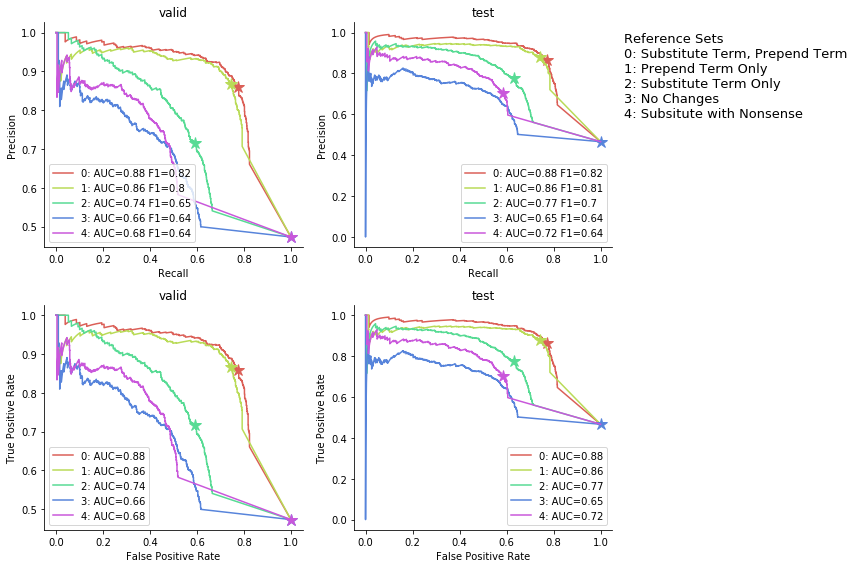

In [48]:
resfiles = experiment['final']
colors = sns.color_palette("hls", len(resfiles))

plt.figure(figsize=(12,8))
plotcounter = 1


for split in ('valid', 'test'):
    plt.subplot(2, 2, plotcounter)
    plotcounter += 1
    plt.title(split)

    for i, resfile in enumerate(resfiles):
        
        df = pd.read_csv(os.path.join('..', resfile), index_col=0)
        df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
        split_df = df[df['split']==split]
        
        prdata = ph.prdata(split_df['label'], split_df['Pred1'])

        plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                 label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                )
        plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    sns.despine()

for split in ('valid', 'test'):
    plt.subplot(2, 2, plotcounter)
    plotcounter += 1
    plt.title(split)

    for i, resfile in enumerate(resfiles):
        
        df = pd.read_csv(os.path.join('..', resfile), index_col=0)
        df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
        split_df = df[df['split']==split]
        
        prdata = ph.prdata(split_df['label'], split_df['Pred1'])
        rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])

        plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                 label=f'{i}: AUC={prdata["pr_auc"]:.2}'
                )
        plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    sns.despine()

plt.subplot(2, 2, 2)
reflegend = 'Reference Sets\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
   
plt.tight_layout()

plt.savefig('../figures/Experiment0-final.pdf')